<img src="assets/pollution.jpeg" width="600" height="400">

# Сегментация загрязнений на основе спутниковых снимков

**Сегментация нефтяных загрязнений** — это важная задача в области экологического мониторинга и анализа данных, которая заключается в автоматическом выделении областей, загрязнённых нефтью, на изображениях или спутниковых снимках. Эта задача играет ключевую роль в оперативном обнаружении и оценке масштабов загрязнений, что позволяет своевременно принимать меры по их ликвидации и минимизировать ущерб для окружающей среды.

Снимки сделанные с помощью SAR являются наиболее подходящими для поиска нефтянных утечек по нескольким причинам:
1. Всепогодность:

    * SAR может работать в любых погодных условиях, включая облачность, туман, дождь и ночное время. Это критически важно для оперативного мониторинга разливов нефти, которые часто происходят в сложных метеоусловиях.

2. Чувствительность к изменениям на поверхности воды:

    * Нефтяные пленки изменяют шероховатость поверхности воды, что влияет на отражение радиоволн. SAR способен улавливать эти изменения, так как нефтяные пятна выглядят как темные области на снимках (из-за снижения обратного рассеяния сигнала).

3. Широкий охват:

    * SAR-спутники могут покрывать большие площади океана, что позволяет оперативно обнаруживать разливы на обширных территориях.

4. Высокая детализация:

    * Современные SAR-системы обеспечивают высокое разрешение, что позволяет обнаруживать даже небольшие разливы нефти.

Датасет со снимками SAR - https://www.kaggle.com/datasets/nabilsherif/oil-spill

In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset

import os
import shutil
import random
import kagglehub 
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Callable

In [2]:
SEED = 666
DATA_PATH = Path('data')
MODELS_PATH = Path('models')
IMG_SIZE = 320
DROPOUT = 0.3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16 
NUM_WORKERS = os.cpu_count()

In [3]:
random.seed(SEED)
    
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Формируем данные

Скачаем датасет и переместим его в нашу папку

In [4]:
DATA_PATH = Path('/kaggle/working/oil-spill')
DATA_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
source = Path(kagglehub.dataset_download("nabilsherif/oil-spill"))

if source.exists():
    shutil.copytree(str(source), '/kaggle/working', dirs_exist_ok=True)
    print(f'Files have been copied to {DATA_PATH}')
else:
    print(f'Folder {source} not found!')

Files have been copied to /kaggle/working/oil-spill


Разработанный набор данных (~400 МБ) содержит около 1000 изображений для обучения и 110 изображений для тестирования, на которых изображены экземпляры 5 классов, а именно: разлив нефти, объекты похожие на разлив нефти, участки суши, судна и моря.

Ссылка на статью про датасет и оценку моделей на нем - https://www.mdpi.com/2072-4292/11/15/1762 

Посмотрим на датасет, какое изображение должно поступать на вход нашей модели и каким должен быть результат

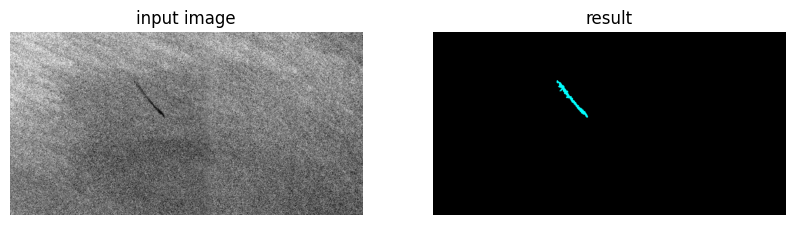

In [6]:
image1 = Image.open(Path(DATA_PATH) / 'train/images/img_0001.jpg')
image2 = Image.open(Path(DATA_PATH) / 'train/labels/img_0001.png')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(image1)
axes[0].axis("off")  
axes[0].set_title("input image")

axes[1].imshow(image2)
axes[1].axis("off")  
axes[1].set_title("result")

plt.show() 

Наша задача по полученному чб снимку, выдать маску на которой голубой цвет соответствует нефтяным пятнам, красный — объектам, похожим на нефтяные пятна, коричневый — кораблям, зеленый — суше, а черный — поверхности моря.

Создадим трансформации которые приведут снимок к нужному размеру и переведут его в `torch.tensor`

In [7]:
X_trans = transforms.Compose([ 
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

y_trans = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:
from torchvision import transforms
import random

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, y):
        for t in self.transforms:
            x, y = t(x, y)
        return x, y

class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return (
            transforms.functional.rotate(x, angle),
            transforms.functional.rotate(y, angle)
        )

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        if random.random() < self.p:
            return (
                transforms.functional.hflip(x),
                transforms.functional.hflip(y)
            )
        return x, y

class RandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        if random.random() < self.p:
            return (
                transforms.functional.vflip(x),
                transforms.functional.vflip(y)
            )
        return x, y

train_transforms = DualCompose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    RandomHorizontalFlip(0.5),   
    RandomVerticalFlip(0.5),     
    lambda x, y: (transforms.ToTensor()(x), transforms.ToTensor()(y)),  
])


val_transforms = DualCompose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    lambda x, y: (transforms.ToTensor()(x), transforms.ToTensor()(y))
])

X_trans_train = transforms.Compose([
    transforms.Lambda(lambda x: train_transforms(x, x)[0]) 
])
X_trans_test = transforms.Compose([
    transforms.Lambda(lambda x:val_transforms(x, x)[0]) 
])

y_trans_train = transforms.Compose([
    transforms.Lambda(lambda y: train_transforms(y, y)[1]) 
])

y_trans_test = transforms.Compose([
    transforms.Lambda(lambda y:val_transforms(y, y)[1])  
])

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, train=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.train = train
        
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        
        if self.train:
            image, mask = X_trans_train(image), X_trans_test(mask)
        else:
            image, mask = y_trans_train(image), y_trans_test(mask)
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)
    

X_train_paths =[f'{DATA_PATH}/train/images/{path}' for path in sorted(list(os.walk(DATA_PATH / 'train/images'))[0][2])]
y_train_paths = [f'{DATA_PATH}/train/labels/{path}' for path in sorted(list(os.walk(DATA_PATH / 'train/labels'))[0][2])]

X_test_paths =[f'{DATA_PATH}/test/images/{path}' for path in sorted(list(os.walk(DATA_PATH / 'test/images'))[0][2])]
y_test_paths = [f'{DATA_PATH}/test/labels/{path}' for path in sorted(list(os.walk(DATA_PATH / 'test/labels'))[0][2])]


train_dataset = SegmentationDataset(image_paths=X_train_paths, 
                                    mask_paths=y_train_paths, 
                                    train=True)
test_dataset = SegmentationDataset(image_paths=X_test_paths, 
                                    mask_paths=y_test_paths, 
                                    train=False)


train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset,
                             shuffle=False,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

In [ ]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        if random.random() < self.p:
            return (
                transforms.functional.hflip(x),
                transforms.functional.hflip(y)
            )
        return x, y

class RandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        if random.random() < self.p:
            return (
                transforms.functional.vflip(x),
                transforms.functional.vflip(y)
            )
        return x, y

base_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, train=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.train = train
        self.horizontal_flip_trans = RandomHorizontalFlip(0.5)
        self.vertical_flip_trans = RandomVerticalFlip(0.5)
        
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        
        if self.train:
            image, mask = self.horizontal_flip_trans(image, mask)
            image, mask = self.vertical_flip_trans(image, mask)
        
        image = base_transforms(image)
        mask = base_transforms(mask)
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

X_train_paths = [f'{DATA_PATH}/train/images/{path}' for path in sorted(os.listdir(DATA_PATH / 'train/images'))]
y_train_paths = [f'{DATA_PATH}/train/labels/{path}' for path in sorted(os.listdir(DATA_PATH / 'train/labels'))]

X_test_paths = [f'{DATA_PATH}/test/images/{path}' for path in sorted(os.listdir(DATA_PATH / 'test/images'))]
y_test_paths = [f'{DATA_PATH}/test/labels/{path}' for path in sorted(os.listdir(DATA_PATH / 'test/labels'))]

train_dataset = SegmentationDataset(
    image_paths=X_train_paths, 
    mask_paths=y_train_paths, 
    train=True
)
test_dataset = SegmentationDataset(
    image_paths=X_test_paths, 
    mask_paths=y_test_paths, 
    train=False
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)
test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

Взглянем на случайные элементы даталоадера

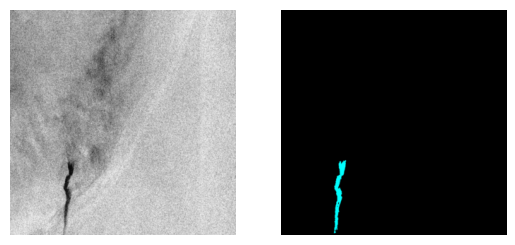

In [11]:
sample = random.choice(train_dataset)
plt.subplot(1, 2, 1)
plt.imshow(sample[0].permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(sample[1].permute(1, 2, 0))
plt.axis(False)

plt.show()

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = None
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class CustomResNetFCN(nn.Module):
    def __init__(self, block, layers, out_channels=3):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
        )

    def _make_layer(self, block, planes, blocks, stride):
        layers = []
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        input_size = x.shape[2:]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.decoder(x)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        return x

resnet_backbone = CustomResNetFCN(BasicBlock, [2, 2, 2, 2], out_channels=3)


In [ ]:
class UNetLarge(nn.Module):
    def __init__(self, backbone, dropout=DROPOUT):
        super().__init__()

        self.backbone = backbone

        self.pool = nn.MaxPool2d(2, 2)

        # Encoder (downsampling path)
        self.encode1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.encode2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.encode3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.encode4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.encode5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Decoder (upsampling path)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decode1 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decode2 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decode3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decode4 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.upconv5 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.decode5 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(32, 3, 1)  # Output layer
        )

    def forward(self, x):
        x = self.backbone(x)
    
        e1 = self.encode1(x)          # 320x320 -> 32 channels
        e2 = self.encode2(self.pool(e1))  # 160x160 -> 64 channels
        e3 = self.encode3(self.pool(e2))  # 80x80 -> 128 channels
        e4 = self.encode4(self.pool(e3))  # 40x40 -> 256 channels
        e5 = self.encode5(self.pool(e4))  # 20x20 -> 512 channels

        # Bottleneck
        bottle = self.bottleneck(self.pool(e5))  # 10x10 -> 1024 channels

        d1 = self.upconv1(bottle)      # 20x20
        d1 = torch.cat([d1, e5], dim=1)
        d1 = self.decode1(d1)          # 20x20 -> 512 channels
        
        d2 = self.upconv2(d1)          # 40x40
        d2 = torch.cat([d2, e4], dim=1)
        d2 = self.decode2(d2)          # 40x40 -> 256 channels
        
        d3 = self.upconv3(d2)          # 80x80
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decode3(d3)          # 80x80 -> 128 channels
        
        d4 = self.upconv4(d3)          # 160x160
        d4 = torch.cat([d4, e2], dim=1)
        d4 = self.decode4(d4)          # 160x160 -> 64 channels
        
        d5 = self.upconv5(d4)          # 320x320
        d5 = torch.cat([d5, e1], dim=1)
        output = self.decode5(d5)      # 320x320 -> 3 channels (output)

        return output

unet_model = UNetLarge(backbone=resnet_backbone,
                       dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=5e-5)
loss_fn = nn.MSELoss()

Посмотрим сколько параметров у модели

In [16]:
def count_params(model: nn.Module):
    count = 0
    for param in model.parameters():
        count += param.numel()
    return count
count_params(unet_model)

45027110

Протестируем модель

In [17]:
test_pred = unet_model(train_dataset[1][0].unsqueeze(0).to(DEVICE))
test_pred.shape

torch.Size([1, 3, 320, 320])

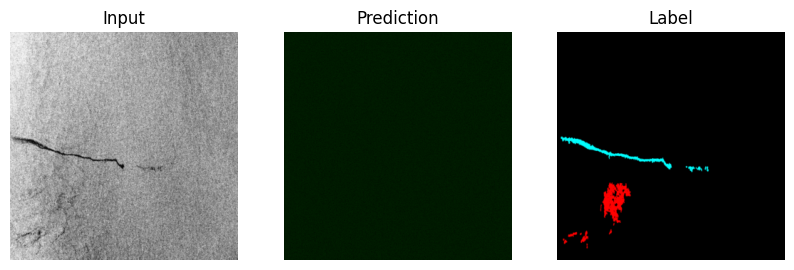

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

sample = train_dataset[1]

test_pred = unet_model(sample[0].unsqueeze(0).to(DEVICE))

axes[0].imshow(sample[0].permute(1, 2, 0))
axes[0].axis(False)
axes[0].set_title('Input')

axes[1].imshow(test_pred[0].permute(1, 2, 0).cpu().detach().numpy())
axes[1].axis(False)
axes[1].set_title('Prediction')

axes[2].imshow(sample[1].permute(1, 2, 0))
axes[2].axis(False)
axes[2].set_title('Label')

plt.show()

Будем использовать следующую метрику:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [19]:
def IoU(pred: torch.tensor, target: torch.tensor, threshold=0.5):
    
    pred = (pred > threshold).float()
    
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    
    iou_value = intersection / union if union != 0 else torch.tensor(0.0)
    
    return iou_value.item()

In [20]:
IoU(test_pred, train_dataset[1][1].unsqueeze(0).to(DEVICE))

0.0

# Обучение

In [21]:
def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim,
          loss_fn: Callable,
          metric_fn: Callable,
          device: str,
          epochs: int,
          use_amp: bool,
          scaler: torch.amp.GradScaler,
          scheduler: torch.optim.lr_scheduler,
          show_step: int):

    results = {'train_loss': [], 'train_met': [], 'test_loss': [], 'test_met': []}
    for epoch in range(epochs):
        train_loss, train_met = 0, 0
        test_loss, test_met = 0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            model.train()
            with torch.autocast(device_type=device, enabled=use_amp):
                y_pred = model(X) 
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            train_loss += loss
            train_met += met
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            model.eval()
            with torch.inference_mode():
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            test_loss += loss
            test_met += met
        scheduler.step()
        if epoch % show_step == 0:
            print(f'EPOCH: {epoch}')
            print(f'train: metric - {train_met / len(train_dataloader)}% loss - {train_loss / len(train_dataloader)}')
            print(f'test: metric - {test_met / len(test_dataloader)}% loss - {test_loss / len(test_dataloader)}')
            print()
        results["train_loss"].append(train_loss / len(train_dataloader))
        results["train_met"].append(train_met / len(train_dataloader))
        results["test_loss"].append(test_loss / len(test_dataloader)) 
        results["test_met"].append(test_met / len(test_dataloader)) 
    return results

Запустим обучение модели

In [22]:
unet_res = train(model=unet_model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                metric_fn=IoU,
                scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 100, 1),
                use_amp=True,
                device=DEVICE,
                scaler=torch.amp.GradScaler(),
                epochs=200,
                show_step=10)

EPOCH: 0
train: metric - 0.013856769367680138% loss - 0.02959148958325386
test: metric - 0.18851881633911813% loss - 0.033858880400657654

EPOCH: 10
train: metric - 0.2018607123681004% loss - 0.019554955884814262
test: metric - 0.1551725704755102% loss - 0.019574962556362152

EPOCH: 20
train: metric - 0.3253802328355729% loss - 0.015075824223458767
test: metric - 0.4153869790690286% loss - 0.011789984069764614

EPOCH: 30
train: metric - 0.4318436999169607% loss - 0.012104605324566364
test: metric - 0.37525406905582975% loss - 0.012136755511164665

EPOCH: 40
train: metric - 0.485139615005917% loss - 0.010516704060137272
test: metric - 0.41527050520692554% loss - 0.012773905880749226

EPOCH: 50
train: metric - 0.5453470656796108% loss - 0.008436564356088638
test: metric - 0.4784244682107653% loss - 0.010576603934168816

EPOCH: 60
train: metric - 0.5576662473262303% loss - 0.007957994937896729
test: metric - 0.443759309394019% loss - 0.011589583940804005

EPOCH: 70
train: metric - 0.60299

# Результаты

Взглянем на графики метрики и ошибки

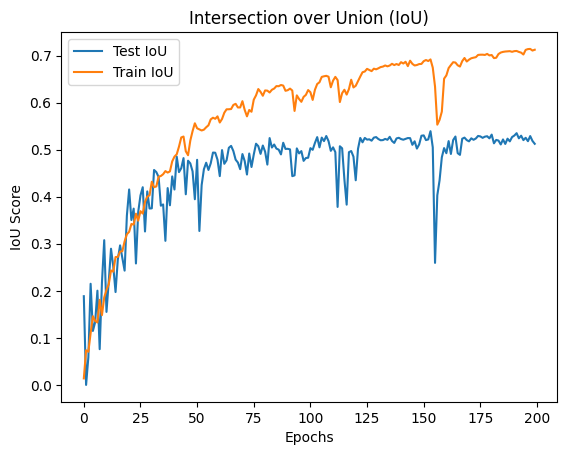

In [23]:
plt.plot(unet_res['test_met'], label='Test IoU')
plt.plot(unet_res['train_met'], label='Train IoU')

plt.title('Intersection over Union (IoU)')
plt.xlabel('Epochs')  
plt.ylabel('IoU Score')  

plt.legend()

plt.show()

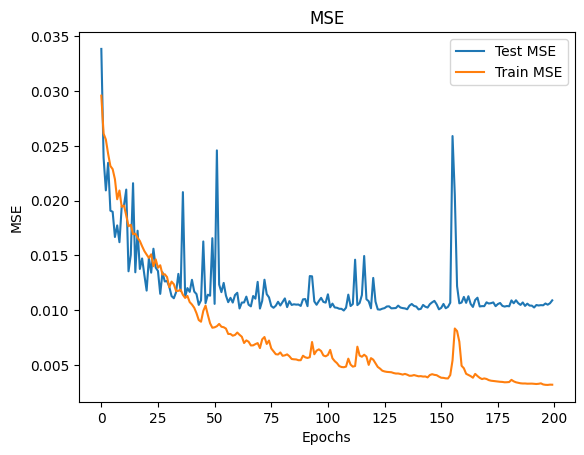

In [24]:
plt.plot([i.item()for i in unet_res['test_loss']], label='Test MSE')
plt.plot([i.item()for i in unet_res['train_loss']], label='Train MSE')

plt.title('MSE')

plt.xlabel('Epochs')  
plt.ylabel('MSE')  

plt.legend()

plt.show()

Оценим предсказание модели

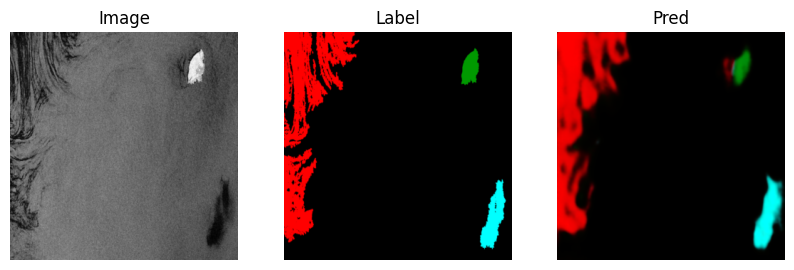

IoU - 0.734326958656311


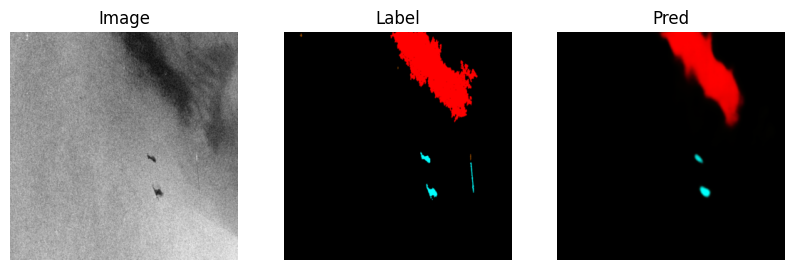

IoU - 0.754991888999939


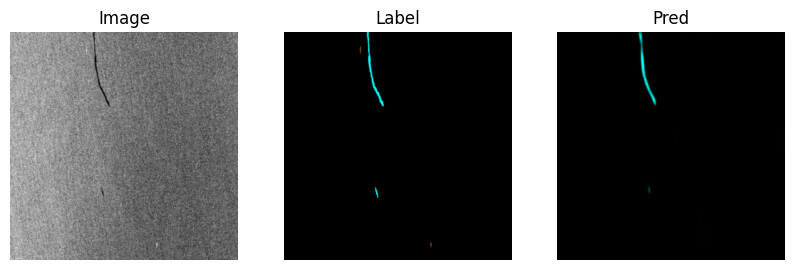

IoU - 0.5833023190498352


In [29]:
unet_model.eval()
for i in range(3):
    ind = random.choice(range(len(test_dataset)))
    sample = test_dataset[ind]
    test_pred = unet_model(sample[0].unsqueeze(0).to(DEVICE))
    fig, axes = plt.subplots(1, 3, figsize=(10, 8))

    axes[0].imshow(sample[0].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis(False)

    axes[1].imshow(sample[1].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Label")
    axes[1].axis(False)

    axes[2].imshow(test_pred.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Pred")
    axes[2].axis(False)

    plt.show()
    print(f"IoU - {IoU(test_pred, test_dataset[ind][1].unsqueeze(0).to(DEVICE))}")

Подводя итоги, можно заключить, что данная архитектура демонстрирует потенциал для решения поставленной задачи. Однако анализ графиков указывает на наличие переобучения модели, что проявляется в снижении её обобщающей способности. Для улучшения результатов в дальнейшем необходимо сосредоточиться на устранении этой проблемы. Возможные направления работы включают: увеличение объема обучающих данных, использование аугментации данных, а также настройку гиперпараметров модели, таких как скорость обучения или размер батча. 

# Сохраняем веса

In [26]:
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)

torch.save(unet_model.state_dict(), f="model_45_mln_52_iou.pth")